# Load Librairies

In [1]:
# Import lib and modules
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc;
from sklearn.model_selection import cross_val_score

In [4]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

/usr/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
def new_features(df):
    # significance of flight distance
    df['Flight_dist_sig'] = df['FlightDistance']/df['FlightDistanceError']
    # momenta p0_pz (along the beam) of the muons
    df['p0_pz'] = np.sqrt(df['p0_p']**2 - df['p0_pt']**2)
    df['p1_pz'] = np.sqrt(df['p1_p']**2 - df['p1_pt']**2)
    df['p2_pz'] = np.sqrt(df['p2_p']**2 - df['p2_pt']**2)
    # momentum p_z (along the beam) of tau
    df['tau_pz'] = df['p0_pt']*np.sinh(df['p0_eta']) + df['p1_pt']*np.sinh(df['p1_eta']) + df['p1_pt']*np.sinh(df['p1_eta'])
    # modulus momentum p of tau
    df['tau_p'] = np.sqrt(df['pt']**2 + df['tau_pz']**2)
    # speed of tau
    df['tau_v'] = df['FlightDistance']/df['LifeTime']
    # mass of tau (momentum over speed)
    df['tau_m'] = df['tau_p']/df['tau_v']
    return df

def __rolling_window(data, window_size):
    """
    Rolling window: take window with definite size through the array
    :param data: array-like
    :param window_size: size
    :return: the sequence of windows
    Example: data = array(1, 2, 3, 4, 5, 6), window_size = 4
        Then this function return array(array(1, 2, 3, 4), array(2, 3, 4, 5), array(3, 4, 5, 6))
    """
    shape = data.shape[:-1] + (data.shape[-1] - window_size + 1, window_size)
    strides = data.strides + (data.strides[-1],)
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)


def __cvm(subindices, total_events):
    """
    Compute Cramer-von Mises metric.
    Compared two distributions, where first is subset of second one.
    Assuming that second is ordered by ascending
    :param subindices: indices of events which will be associated with the first distribution
    :param total_events: count of events in the second distribution
    :return: cvm metric
    """
    target_distribution = np.arange(1, total_events + 1, dtype='float') / total_events
    subarray_distribution = np.cumsum(np.bincount(subindices, minlength=total_events), dtype='float')
    subarray_distribution /= 1.0 * subarray_distribution[-1]
    return np.mean((target_distribution - subarray_distribution) ** 2)


def compute_cvm(predictions, masses, n_neighbours=200, step=50):
    """
    Computing Cramer-von Mises (cvm) metric on background events: take average of cvms calculated for each mass bin.
    In each mass bin global prediction's cdf is compared to prediction's cdf in mass bin.
    :param predictions: array-like, predictions
    :param masses: array-like, in case of Kaggle tau23mu this is reconstructed mass
    :param n_neighbours: count of neighbours for event to define mass bin
    :param step: step through sorted mass-array to define next center of bin
    :return: average cvm value
    """
    predictions = np.array(predictions)
    masses = np.array(masses)
    assert len(predictions) == len(masses)

    # First, reorder by masses
    predictions = predictions[np.argsort(masses)]

    # Second, replace probabilities with order of probability among other events
    predictions = np.argsort(np.argsort(predictions, kind='mergesort'), kind='mergesort')

    # Now, each window forms a group, and we can compute contribution of each group to CvM
    cvms = []
    for window in __rolling_window(predictions, window_size=n_neighbours)[::step]:
        cvms.append(__cvm(subindices=window, total_events=len(predictions)))
    return np.mean(cvms)


def __roc_curve_splitted(data_zero, data_one, sample_weights_zero, sample_weights_one):
    """
    Compute roc curve
    :param data_zero: 0-labeled data
    :param data_one:  1-labeled data
    :param sample_weights_zero: weights for 0-labeled data
    :param sample_weights_one:  weights for 1-labeled data
    :return: roc curve
    """
    labels = [0] * len(data_zero) + [1] * len(data_one)
    weights = np.concatenate([sample_weights_zero, sample_weights_one])
    data_all = np.concatenate([data_zero, data_one])
    fpr, tpr, _ = roc_curve(labels, data_all, sample_weight=weights)
    return fpr, tpr


def compute_ks(data_prediction, mc_prediction, weights_data, weights_mc):
    """
    Compute Kolmogorov-Smirnov (ks) distance between real data predictions cdf and Monte Carlo one.
    :param data_prediction: array-like, real data predictions
    :param mc_prediction: array-like, Monte Carlo data predictions
    :param weights_data: array-like, real data weights
    :param weights_mc: array-like, Monte Carlo weights
    :return: ks value
    """
    assert len(data_prediction) == len(weights_data), 'Data length and weight one must be the same'
    assert len(mc_prediction) == len(weights_mc), 'Data length and weight one must be the same'

    data_prediction, mc_prediction = np.array(data_prediction), np.array(mc_prediction)
    weights_data, weights_mc = np.array(weights_data), np.array(weights_mc)

    assert np.all(data_prediction >= 0.) and np.all(data_prediction <= 1.), 'Data predictions are out of range [0, 1]'
    assert np.all(mc_prediction >= 0.) and np.all(mc_prediction <= 1.), 'MC predictions are out of range [0, 1]'

    weights_data /= np.sum(weights_data)
    weights_mc /= np.sum(weights_mc)

    fpr, tpr = __roc_curve_splitted(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = np.max(np.abs(fpr - tpr))
    return Dnm


def roc_auc_truncated(labels, predictions, tpr_thresholds=(0.2, 0.4, 0.6, 0.8),
                      roc_weights=(4, 3, 2, 1, 0)):
    """
    Compute weighted area under ROC curve.
    :param labels: array-like, true labels
    :param predictions: array-like, predictions
    :param tpr_thresholds: array-like, true positive rate thresholds delimiting the ROC segments
    :param roc_weights: array-like, weights for true positive rate segments
    :return: weighted AUC
    """
    assert np.all(predictions >= 0.) and np.all(predictions <= 1.), 'Data predictions are out of range [0, 1]'
    assert len(tpr_thresholds) + 1 == len(roc_weights), 'Incompatible lengths of thresholds and weights'
    fpr, tpr, _ = roc_curve(labels, predictions)
    area = 0.
    tpr_thresholds = [0.] + list(tpr_thresholds) + [1.]
    for index in range(1, len(tpr_thresholds)):
        tpr_cut = np.minimum(tpr, tpr_thresholds[index])
        tpr_previous = np.minimum(tpr, tpr_thresholds[index - 1])
        area += roc_weights[index - 1] * (auc(fpr, tpr_cut, reorder=True) - auc(fpr, tpr_previous, reorder=True))
    tpr_thresholds = np.array(tpr_thresholds)
    # roc auc normalization to be 1 for an ideal classifier
    area /= np.sum((tpr_thresholds[1:] - tpr_thresholds[:-1]) * np.array(roc_weights))
    return area

def check_agreement(clf):
    """
    Return KS metric for a given classifier and print test result
    """
    check_agreement = pd.read_csv(folder + 'check_agreement.csv', index_col='id')
    new_features(check_agreement)
    agreement_probs = clf.predict_proba(check_agreement[variables])[:, 1]
    ks = compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
    print('KS metric', ks, ks < 0.09)
    return ks
    
def check_correlation(clf):
    """
    Return cvm metric for a given classifier and print test result
    """
    check_correlation = pd.read_csv(folder + 'check_correlation.csv', index_col='id')
    new_features(check_correlation)
    correlation_probs = clf.predict_proba(check_correlation[variables])[:, 1]
    cvm = compute_cvm(correlation_probs, check_correlation['mass'])
    print('CvM metric', cvm, cvm < 0.002)
    return cvm

def compute_AUC(clf, train_data):
    """
    Compute weighted AUC on the training data with min_ANNmuon > 0.4
    """
    train_eval = train_data[train_data['min_ANNmuon'] > 0.4]
    train_probs = clf.predict_proba(train_eval[variables])[:, 1]
    AUC = roc_auc_truncated(train_eval['signal'], train_probs)
    return AUC
    print('AUC', AUC)

# Load Data

In [53]:
# Load training data
folder = 'data/'
train = pd.read_csv(folder + 'training.csv', index_col='id')
print('reading training data...')
train.head()
variables = list(train.columns) 
var_out = ['SPDhits', 'production', 'signal', 'mass','id','min_ANNmuon']
variables = [v for v in variables if v not in var_out]

reading training data...


# Split in K-Fold for Cross-Validation

In [5]:
kf = KFold(len(train), n_folds=5, random_state=555, shuffle=True)

# Naive Bayes Classifier

### Train

In [9]:
from sklearn.naive_bayes import GaussianNB
results =[]
for train_idx, test_idx in kf:
    X_train = train[variables].iloc[train_idx]
    y_train = train['signal'].iloc[train_idx]
    X_test = train[variables].iloc[test_idx]
    y_test = train['signal'].iloc[test_idx]
    
    gnb = GaussianNB()
    gnb.fit(X_train,y_train)
    
    predict_proba = gnb.predict_proba(X_test)[:,1]
    results.append(roc_auc_truncated(y_test, predict_proba))
print('mean AUC', np.mean(np.asarray(results)))    

mean AUC 0.961283826268


### Additional Tests

In [42]:
a = check_agreement(gnb)
b = check_correlation(gnb)

KS metric 0.0307184785279 True
CvM metric 0.00098074500991 True


# Decision Tree Classifier

## Train

In [6]:
results = []
for i in range (1,100):
    AUC = []
    for train_idx, test_idx in kf:
        X_train = train[variables].iloc[train_idx]
        y_train = train['signal'].iloc[train_idx]
        X_test = train[variables].iloc[test_idx]
        y_test = train['signal'].iloc[test_idx]

        clf1 = DecisionTreeClassifier(random_state=0, max_depth=i)
        clf1.fit(X_train, y_train)
        predict_proba = clf1.predict_proba(X_test)[:,1]
        AUC.append(roc_auc_truncated(y_test, predict_proba))
    results.append(AUC)

In [7]:
x = np.linspace(1,100,100)
y = 1-np.mean(np.asarray(results),axis=1)

### Plot

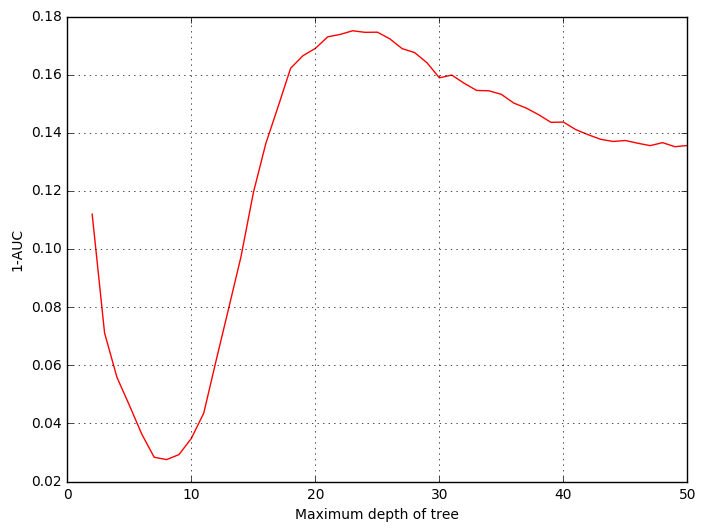

In [46]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x[1:50],y[0:49],color='r')
plt.xlabel('Maximum depth of tree')
plt.ylabel('1-AUC')
plt.grid(True)
#plt.savefig("test.png")
plt.show()

### Best hyper-parameters

In [38]:
print (1-np.min(y),np.argmin(y))

0.972462418901 6


### Additonal Tests

In [37]:
for train_idx, test_idx in kf:
        X_train = train[variables].iloc[train_idx]
        y_train = train['signal'].iloc[train_idx]
        X_test = train[variables].iloc[test_idx]
        y_test = train['signal'].iloc[test_idx]

        clf1 = DecisionTreeClassifier(random_state=0, max_depth=6)
        clf1.fit(X_train, y_train)
        check_agreement(clf1)
        check_correlation(clf1)

KS metric 0.0354917615126 True
CvM metric 0.001051282536 True
KS metric 0.0445140670933 True
CvM metric 0.00104243772874 True
KS metric 0.0455357741279 True
CvM metric 0.00117721033925 True
KS metric 0.0448501405167 True
CvM metric 0.00128238189044 True
KS metric 0.0333243828262 True
CvM metric 0.00103781129291 True


# AdaBoost Tree Classifier

### Train

In [12]:
results = []

depth = 1
nestimators=100
minsampleleafs = 1
j=0
for train_idx, test_idx in kf:
    AUC = []
    X_train = train[variables].iloc[train_idx]
    y_train = train['signal'].iloc[train_idx]
    X_test = train[variables].iloc[test_idx]
    y_test = train['signal'].iloc[test_idx]

    clf1 = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf=minsampleleafs, random_state=0, max_depth=depth), algorithm = "SAMME.R", 
                              n_estimators = nestimators)
    
    # Compute weighted AUC on the training data with min_ANNmuon > 0.4¶
    clf1.fit(X_train, y_train)
    genProbs = clf1.staged_predict_proba(X_test)
    
    for i in range(0,nestimators):
        AUC.append(roc_auc_truncated(y_test, next(genProbs)[:,1]))
    
    results.append(AUC)
    j=j+1
    print(j)

1
2
3
4
5


In [21]:
depth1 = 1-np.mean(np.asarray(results),axis=0)

In [23]:
#np.savetxt('depth1.txt', depth1, fmt='%f')
#np.savetxt('depth2.txt', depth2, fmt='%f')
#np.savetxt('depth3.txt', depth3, fmt='%f')

In [28]:
depth1 = np.loadtxt('depth1.txt')
depth2 = np.loadtxt('depth2.txt')
depth3 = np.loadtxt('depth3.txt')

### Plot

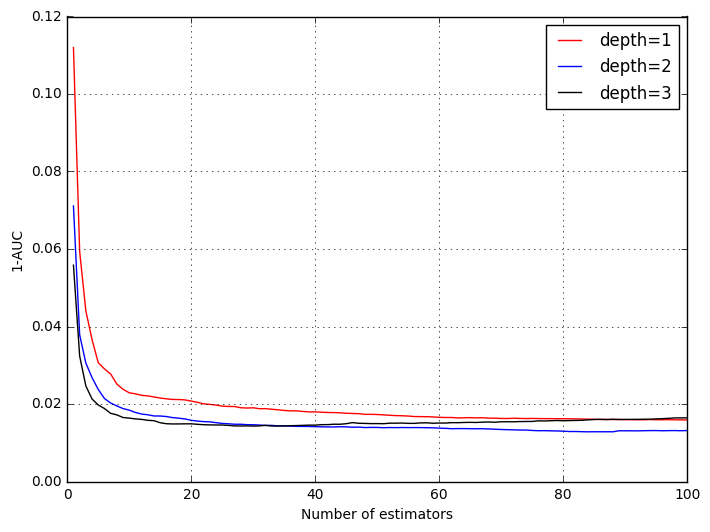

In [47]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x[0:100],depth1[0:100],color='r',label='depth=1')
plt.plot(x[0:100],depth2[0:100],color='b',label='depth=2')
plt.plot(x[0:100],depth3[0:100],color='k',label='depth=3')
plt.xlabel('Number of estimators')
plt.ylabel('1-AUC')
plt.legend()
plt.grid(True)
plt.show()

### Best hyper-parameters

In [35]:
print(1-np.min(depth1),np.argmin(depth1))
print(1-np.min(depth2),np.argmin(depth2))
print(1-np.min(depth3),np.argmin(depth3))

0.985012 343
0.987178 83
0.985705 29


### Additional Tests

In [39]:
for train_idx, test_idx in kf:
    X_train = train[variables].iloc[train_idx]
    y_train = train['signal'].iloc[train_idx]
    X_test = train[variables].iloc[test_idx]
    y_test = train['signal'].iloc[test_idx]

    clf1 = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf=minsampleleafs, random_state=0, max_depth=2), algorithm = "SAMME.R", 
                              n_estimators = 83)
    
    clf1.fit(X_train, y_train)
    check_agreement(clf1)
    check_correlation(clf1)

KS metric 0.0907679900406 False
CvM metric 0.00084405548798 True
KS metric 0.107755509414 False
CvM metric 0.00091169647502 True
KS metric 0.100260195415 False
CvM metric 0.000844029266993 True
KS metric 0.0923310954214 False
CvM metric 0.000914992358333 True
KS metric 0.0952349718036 False
CvM metric 0.000840805627813 True


# TSV Format for TSN-e

In [62]:
variables = list(train.columns) 
var_out = ['SPDhits', 'production', 'mass','id','min_ANNmuon']
variables = [v for v in variables if v not in var_out]
pd.DataFrame(train[variables]).to_csv('output.tsv',sep='\t',index=False,header=True, quoting=csv.QUOTE_NONE)

http://projector.tensorflow.org/